## Purpose : testing the effect of noise on LRA and the how the filter SNR($U_i$) >1 works

##### 2025.06.14 : AR

------

### Importing dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib
######################################################
matplotlib.rcParams['text.usetex'] = False
import matplotlib.pyplot as plt

font = {'weight' : 'regular',
        'size'   : 22}

plt.rc('font', **font)

import matplotlib.font_manager as font_manager

plt.rcParams["figure.figsize"] = (8,7)
######################################################

from src import lra_core
from src import qplot
import random
import math
from scipy.optimize import curve_fit
from scipy.stats import norm


------

#### Following block prepares the true dataset, and test dataset, and performs analysis within a loop

In [2]:
# check settings for customization 

# --- Settings ---
xdim = 900
xmin, xmax = 0.2, 30
xaxis = np.linspace(xmin, xmax, xdim)
cols = 200

#--------------------------------------
Noise_sDev = 30  #   Change this for testing other noise levels <<
ranks = np.arange(3, 11)   # change this for which LRA ranks to analyse
#--------------------------------------

# --- Peak definitions ---
centers = [9.5, 12, 16, 20, 24, 26.5]
widths = [0.35, 0.25, 0.62, 0.25, 0.60, 0.88]
amplitudes = [50, 28, 19, 8, 17, 11]  # Base amplitudes

# --- Generate true components (3 signals) ---
gaussians = [A * norm.pdf(xaxis, loc=mu, scale=sig)
             for A, mu, sig in zip(amplitudes, centers, widths)]
signal1 = gaussians[0] + gaussians[1]
signal2 = gaussians[2] + gaussians[3]
signal3 = gaussians[4] + gaussians[5]

# --- Generate true dataset by mixing signals ---
true_data = np.zeros((xdim, cols))
mix_ratios = np.zeros((cols, 3))

np.random.seed(0)
for i in range(cols):
    coefs = np.random.uniform(0.4, 3.5, 3)
    mix_ratios[i] = coefs
    true_data[:, i] = coefs[0]*signal1 + coefs[1]*signal2 + coefs[2]*signal3
    if i==10 or i==20 or i==30 :
        true_data[:, i] = 0 
    

# Save mix ratio of col 0
col0_mix_ratio = mix_ratios[0].copy()

# --- Gaussian fitting model (6 peaks + offset) ---
def multi_gaussian(x, *params):
    y = np.zeros_like(x)
    for i in range(6):
        A, x0, sigma = params[i*3:(i+1)*3]
        y += A * np.exp(-(x - x0)**2 / (2 * sigma**2))
    y += params[-1]  # offset
    return y

def extract_metrics(popt):
    peaks = []
    for i in range(6):
        A = popt[i*3]
        x0 = popt[i*3 + 1]
        sigma = popt[i*3 + 2]
        area = A * sigma * np.sqrt(2 * np.pi)
        peaks.append({"A": A, "x0": x0, "sigma": sigma, "area": area})
    return peaks

# --- Fit col 0 of true dataset ---
p0 = []
for i in range(6):
    p0.extend([amplitudes[i], centers[i], widths[i]])
p0.append(0)  # offset

popt_true, _ = curve_fit(multi_gaussian, xaxis, true_data[:, 0], p0=p0, maxfev=5000)
true_params = extract_metrics(popt_true)

# --- Add noise to dataset ---
test_data = np.zeros_like(true_data)
np.random.seed(42)
for i in range(cols):
    noise = np.random.normal(0, Noise_sDev, xdim)
    test_data[:, i] = true_data[:, i] + noise

# Add linear baseline to half of the test_data (i > 100)
slope, offset = 0.75, 1
baseline = slope * xaxis + offset
baseline2 = -slope*1.2 * xaxis + offset

# two kind of baseline is added.
for i in range(101, cols):
    if i%2 == 0:
        test_data[:, i] += baseline
    elif i%7 == 0:
        test_data[:, i] += baseline  + (slope*0.024 * xaxis**2) 
    
# --- Noise region for SNR ---
noise_mask = (xaxis >= 1.2) & (xaxis <= 7.8)
noise_indices = np.where(noise_mask)[0]

# --- Storage ---
results = {i: {"height": [], "width": [], "pos": [], "area": [], "snr": []} for i in range(6)}
errors = {i: {"height_err": [], "pos_err": [], "width_err": []} for i in range(6)}

def low_rank_approximation(data, rank):
    u, s, vt = np.linalg.svd(data, full_matrices=False)
    s[rank:] = 0
    return u @ np.diag(s) @ vt, s

# --- Analyze fixed column across LRA ranks ---
col_index = 0
for rank in ranks:
    approx, _ = low_rank_approximation(test_data, rank)
    col = approx[:, col_index]
    
    bg = col[noise_indices]
    bg_mean = np.mean(bg)
    bg_std = np.std(bg)

    
    try:
        # Add small noise to the initial guess
        noise_level = 0.02
        p0_noisy = popt_true * (1 + noise_level * np.random.uniform(-1, 1, size=len(popt_true)))

        popt_noisy, pcov = curve_fit(multi_gaussian, xaxis, col, p0=p0_noisy, maxfev=5000)

        perr = np.sqrt(np.diag(pcov))
        fit_params = extract_metrics(popt_noisy)

        for i in range(6):
            A_fit = fit_params[i]["A"]
            x_fit = fit_params[i]["x0"]
            sigma_fit = fit_params[i]["sigma"]
            area_fit = fit_params[i]["area"]
            
            A_ref = true_params[i]["A"]
            x_ref = true_params[i]["x0"]
            sigma_ref = true_params[i]["sigma"]
            area_ref = true_params[i]["area"]
            
            results[i]["height"].append(100 * (A_fit - A_ref) / A_ref)
            results[i]["width"].append(100 * (sigma_fit - sigma_ref) / sigma_ref)
            results[i]["pos"].append(100 * (x_fit - x_ref) / x_ref)
            results[i]["area"].append(100 * (area_fit - area_ref) / area_ref)
            
            # % fit errors
            A_pct_err = 100 * perr[i*3] / A_fit if A_fit != 0 else np.nan
            x_pct_err = 100 * perr[i*3+1] / x_fit if x_fit != 0 else np.nan
            sigma_pct_err = 100 * perr[i*3+2] / sigma_fit if sigma_fit != 0 else np.nan
            
            errors[i]["height_err"].append(A_pct_err)
            errors[i]["pos_err"].append(x_pct_err)
            errors[i]["width_err"].append(sigma_pct_err)
            
            # SNR
            contrast = (A_fit + popt_noisy[-1]) - bg_mean
            snr = contrast / bg_std if bg_std > 0 else np.nan
            results[i]["snr"].append(snr)

    except RuntimeError:
        for i in range(6):
            results[i]["height"].append(np.nan)
            results[i]["width"].append(np.nan)
            results[i]["pos"].append(np.nan)
            results[i]["area"].append(np.nan)
            results[i]["snr"].append(np.nan)
            errors[i]["height_err"].append(np.nan)
            errors[i]["pos_err"].append(np.nan)
            errors[i]["width_err"].append(np.nan)

print(col0_mix_ratio, true_params)
#-----------------------------------------

# --- Mix Ratio Recovery from LRA ---
recovered_ratios = []
deviation_percent = []

for rank in ranks:
    approx, _ = low_rank_approximation(test_data, rank)
    col = approx[:, col_index]

    # Fit the reconstructed col0 as linear combination of signal1/2/3
    signals_matrix = np.vstack([signal1, signal2, signal3]).T
    coefs, _, _, _ = np.linalg.lstsq(signals_matrix, col, rcond=None)
    recovered_ratios.append(coefs)

    pct_diff = 100 * (coefs - col0_mix_ratio) / col0_mix_ratio
    deviation_percent.append(pct_diff)

recovered_ratios = np.array(recovered_ratios)
deviation_percent = np.array(deviation_percent)



[2.10132186 2.61708704 2.26856647] [{'A': 119.75801936686908, 'x0': 9.499999999999996, 'sigma': 0.3500000000111703, 'area': 105.06609311393353}, {'A': 93.89028718413377, 'x0': 12.000000000000007, 'sigma': 0.2500000000098502, 'area': 58.837012144561804}, {'A': 31.995591503967436, 'x0': 15.999999999999888, 'sigma': 0.6200000000630755, 'area': 49.7246536880394}, {'A': 33.41013344401622, 'x0': 20.000000000000156, 'sigma': 0.2500000000247723, 'area': 20.93669628956606}, {'A': 25.64243391061341, 'x0': 23.99999999997415, 'sigma': 0.600000000050301, 'area': 38.565629925653354}, {'A': 11.312838491767634, 'x0': 26.500000000044647, 'sigma': 0.8800000001295591, 'area': 24.95423113389675}]


-------

### True signals and baseline

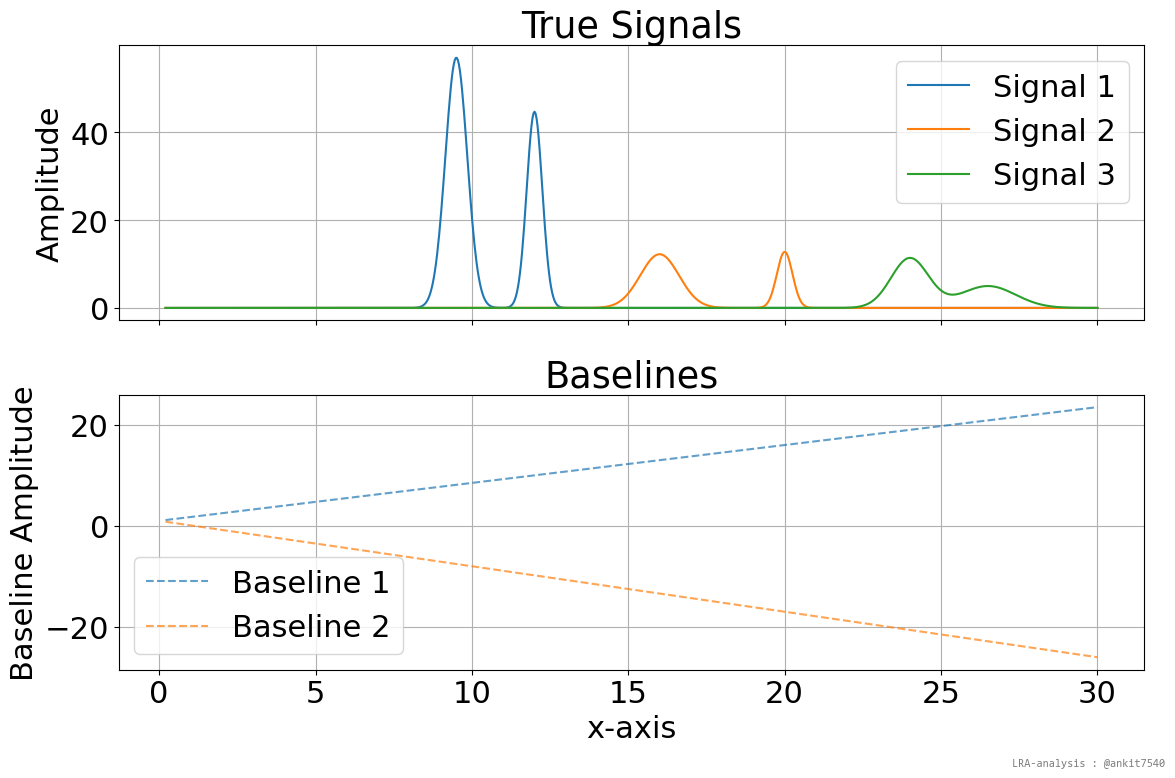

In [3]:
# --- Plotting true signals and baseline  ---
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Row 1: Signals
axes[0].plot(xaxis, signal1, label="Signal 1", color='tab:blue')
axes[0].plot(xaxis, signal2, label="Signal 2", color='tab:orange')
axes[0].plot(xaxis, signal3, label="Signal 3", color='tab:green')
axes[0].set_ylabel("Amplitude")
axes[0].legend()
axes[0].set_title("True Signals")
axes[0].grid()
plt.grid()
# Row 2: Baselines
axes[1].plot(xaxis, baseline, '--', label="Baseline 1", color='tab:blue', alpha=0.7)
axes[1].plot(xaxis, baseline2, '--', label="Baseline 2", color='tab:orange', alpha=0.7)
#axes[1].plot(xaxis, baseline3, '--', label="Baseline 3", color='tab:green', alpha=0.7)
axes[1].set_ylabel("Baseline Amplitude")
axes[1].set_xlabel("x-axis")
axes[1].legend()
axes[1].set_title("Baselines")

plt.tight_layout()

# Attribution text (bottom right)
fig.text(
    0.99,         # x-coordinate in figure fraction
    0.01,         # y-coordinate in figure fraction
    "LRA-analysis : @ankit7540",  # Text content
    ha='right', 
    va='bottom',
    fontsize=8,
    color='gray',
    fontname='Consolas'  # Or try 'Arial Narrow'
)
plt.show()


### View the `test_data` as an image

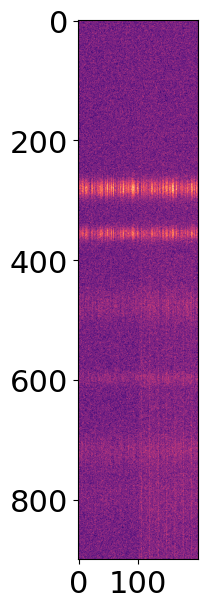

In [4]:
plt.imshow(test_data, cmap='magma')

------

### Check output from SNR($U_i$)>1 filter

In [5]:
#-------------------------------------------------------
cutoffV = lra_core.SNR_cutoff( xaxis , 
                             test_data, 
                             8  )

	 SNR :  [11.61072325  3.51092683  1.67809107  1.2210452   0.77777235  0.85238567
  0.77584514  0.87216009  0.85980539  0.78195579  0.75479991  0.86082885
  0.80759246  0.78173569]
	 Determined auto-cutoff (based on SNR) :  4


------

### Check column 0 of the test and true dataset 

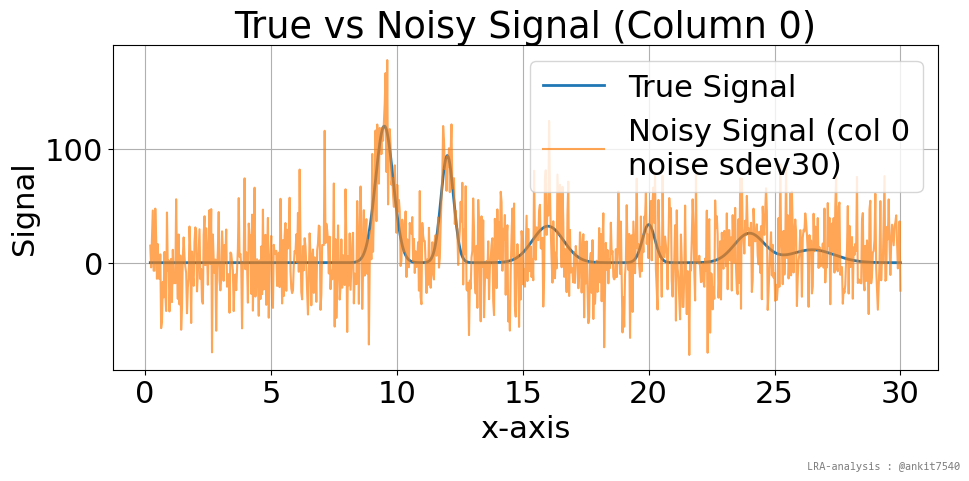

In [6]:

# Plot true signal and noisy signal for col 10
col_index_plot = col_index


plt.figure(figsize=(10, 5))
plt.plot(xaxis, true_data[:, col_index_plot], label='True Signal', linewidth=2)
plt.plot(xaxis, test_data[:, col_index_plot], label=f'Noisy Signal (col {col_index_plot}\nnoise sdev{Noise_sDev})', 
         alpha=0.7)
plt.xlabel("x-axis")
plt.ylabel("Signal")
plt.title(f"True vs Noisy Signal (Column {col_index_plot})")
plt.legend()
plt.tight_layout()
plt.grid()

# ----------------------------- 
plt.figtext(
    0.989,         # x-coordinate in figure fraction
    0.01,         # y-coordinate in figure fraction
    "LRA-analysis : @ankit7540",  # Text content
    ha='right', 
    va='bottom',
    fontsize=8,
    color='gray',
    fontname='Consolas'  # Or try 'Arial Narrow'
)


plt.show()

Text(0.989, 0.01, 'LRA-analysis : @ankit7540')

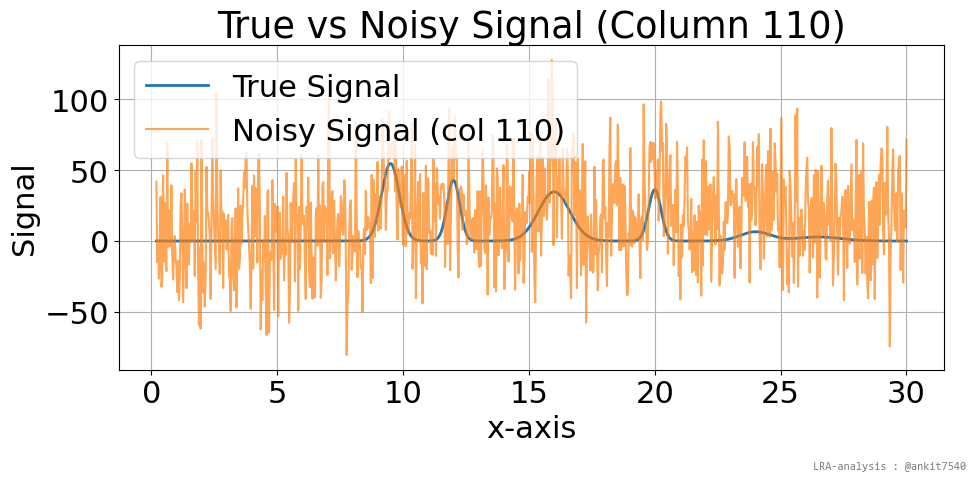

In [7]:
col_index_plot = 110
plt.figure(figsize=(10, 5))
plt.plot(xaxis, true_data[:, col_index_plot], label='True Signal', linewidth=2)
plt.plot(xaxis, test_data[:, col_index_plot], label=f'Noisy Signal (col {col_index_plot})', alpha=0.7)
plt.xlabel("x-axis")
plt.ylabel("Signal")
plt.title(f"True vs Noisy Signal (Column {col_index_plot})")
plt.legend()
plt.tight_layout()
plt.grid()
# ----------------------------- 
# Attribution text (bottom right)
plt.figtext(
    0.989,         # x-coordinate in figure fraction
    0.01,         # y-coordinate in figure fraction
    "LRA-analysis : @ankit7540",  # Text content
    ha='right', 
    va='bottom',
    fontsize=8,
    color='gray',
    fontname='Consolas'  # Or try 'Arial Narrow'
)


-------

### Check the obtained coefficients from test dataset 
#### (deviation from true is shown)

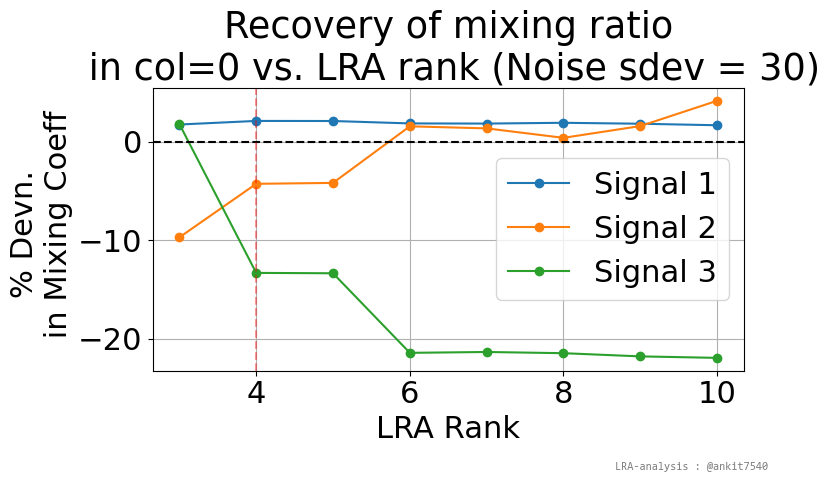

In [8]:
plt.figure(figsize=(8, 5))
for i in range(3):
    plt.plot(ranks, deviation_percent[:, i], marker='o', label=f'Signal {i+1}')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('LRA Rank')
plt.ylabel('% Devn. \n in Mixing Coeff')
plt.title('Recovery of mixing ratio\n in col=0 vs. LRA rank '+'(Noise sdev = '+str(Noise_sDev)+')')
plt.legend()
plt.grid(True)
plt.tight_layout()

ax = plt.gca()
ax.axvline(cutoffV, color='red', linestyle='--', alpha=0.4)


# ----------------------------- 
# Attribution text (bottom right)
plt.figtext(
    0.989,         # x-coordinate in figure fraction
    0.01,         # y-coordinate in figure fraction
    "LRA-analysis : @ankit7540",  # Text content
    ha='right', 
    va='bottom',
    fontsize=8,
    color='gray',
    fontname='Consolas'  # Or try 'Arial Narrow'
)

plt.show()


------

-----

In [9]:
print(true_params)

[{'A': 119.75801936686908, 'x0': 9.499999999999996, 'sigma': 0.3500000000111703, 'area': 105.06609311393353}, {'A': 93.89028718413377, 'x0': 12.000000000000007, 'sigma': 0.2500000000098502, 'area': 58.837012144561804}, {'A': 31.995591503967436, 'x0': 15.999999999999888, 'sigma': 0.6200000000630755, 'area': 49.7246536880394}, {'A': 33.41013344401622, 'x0': 20.000000000000156, 'sigma': 0.2500000000247723, 'area': 20.93669628956606}, {'A': 25.64243391061341, 'x0': 23.99999999997415, 'sigma': 0.600000000050301, 'area': 38.565629925653354}, {'A': 11.312838491767634, 'x0': 26.500000000044647, 'sigma': 0.8800000001295591, 'area': 24.95423113389675}]


###  Visualize the deviation in peak parameters and SNR for LRA approximations
#### (column 0 is being analyzed)

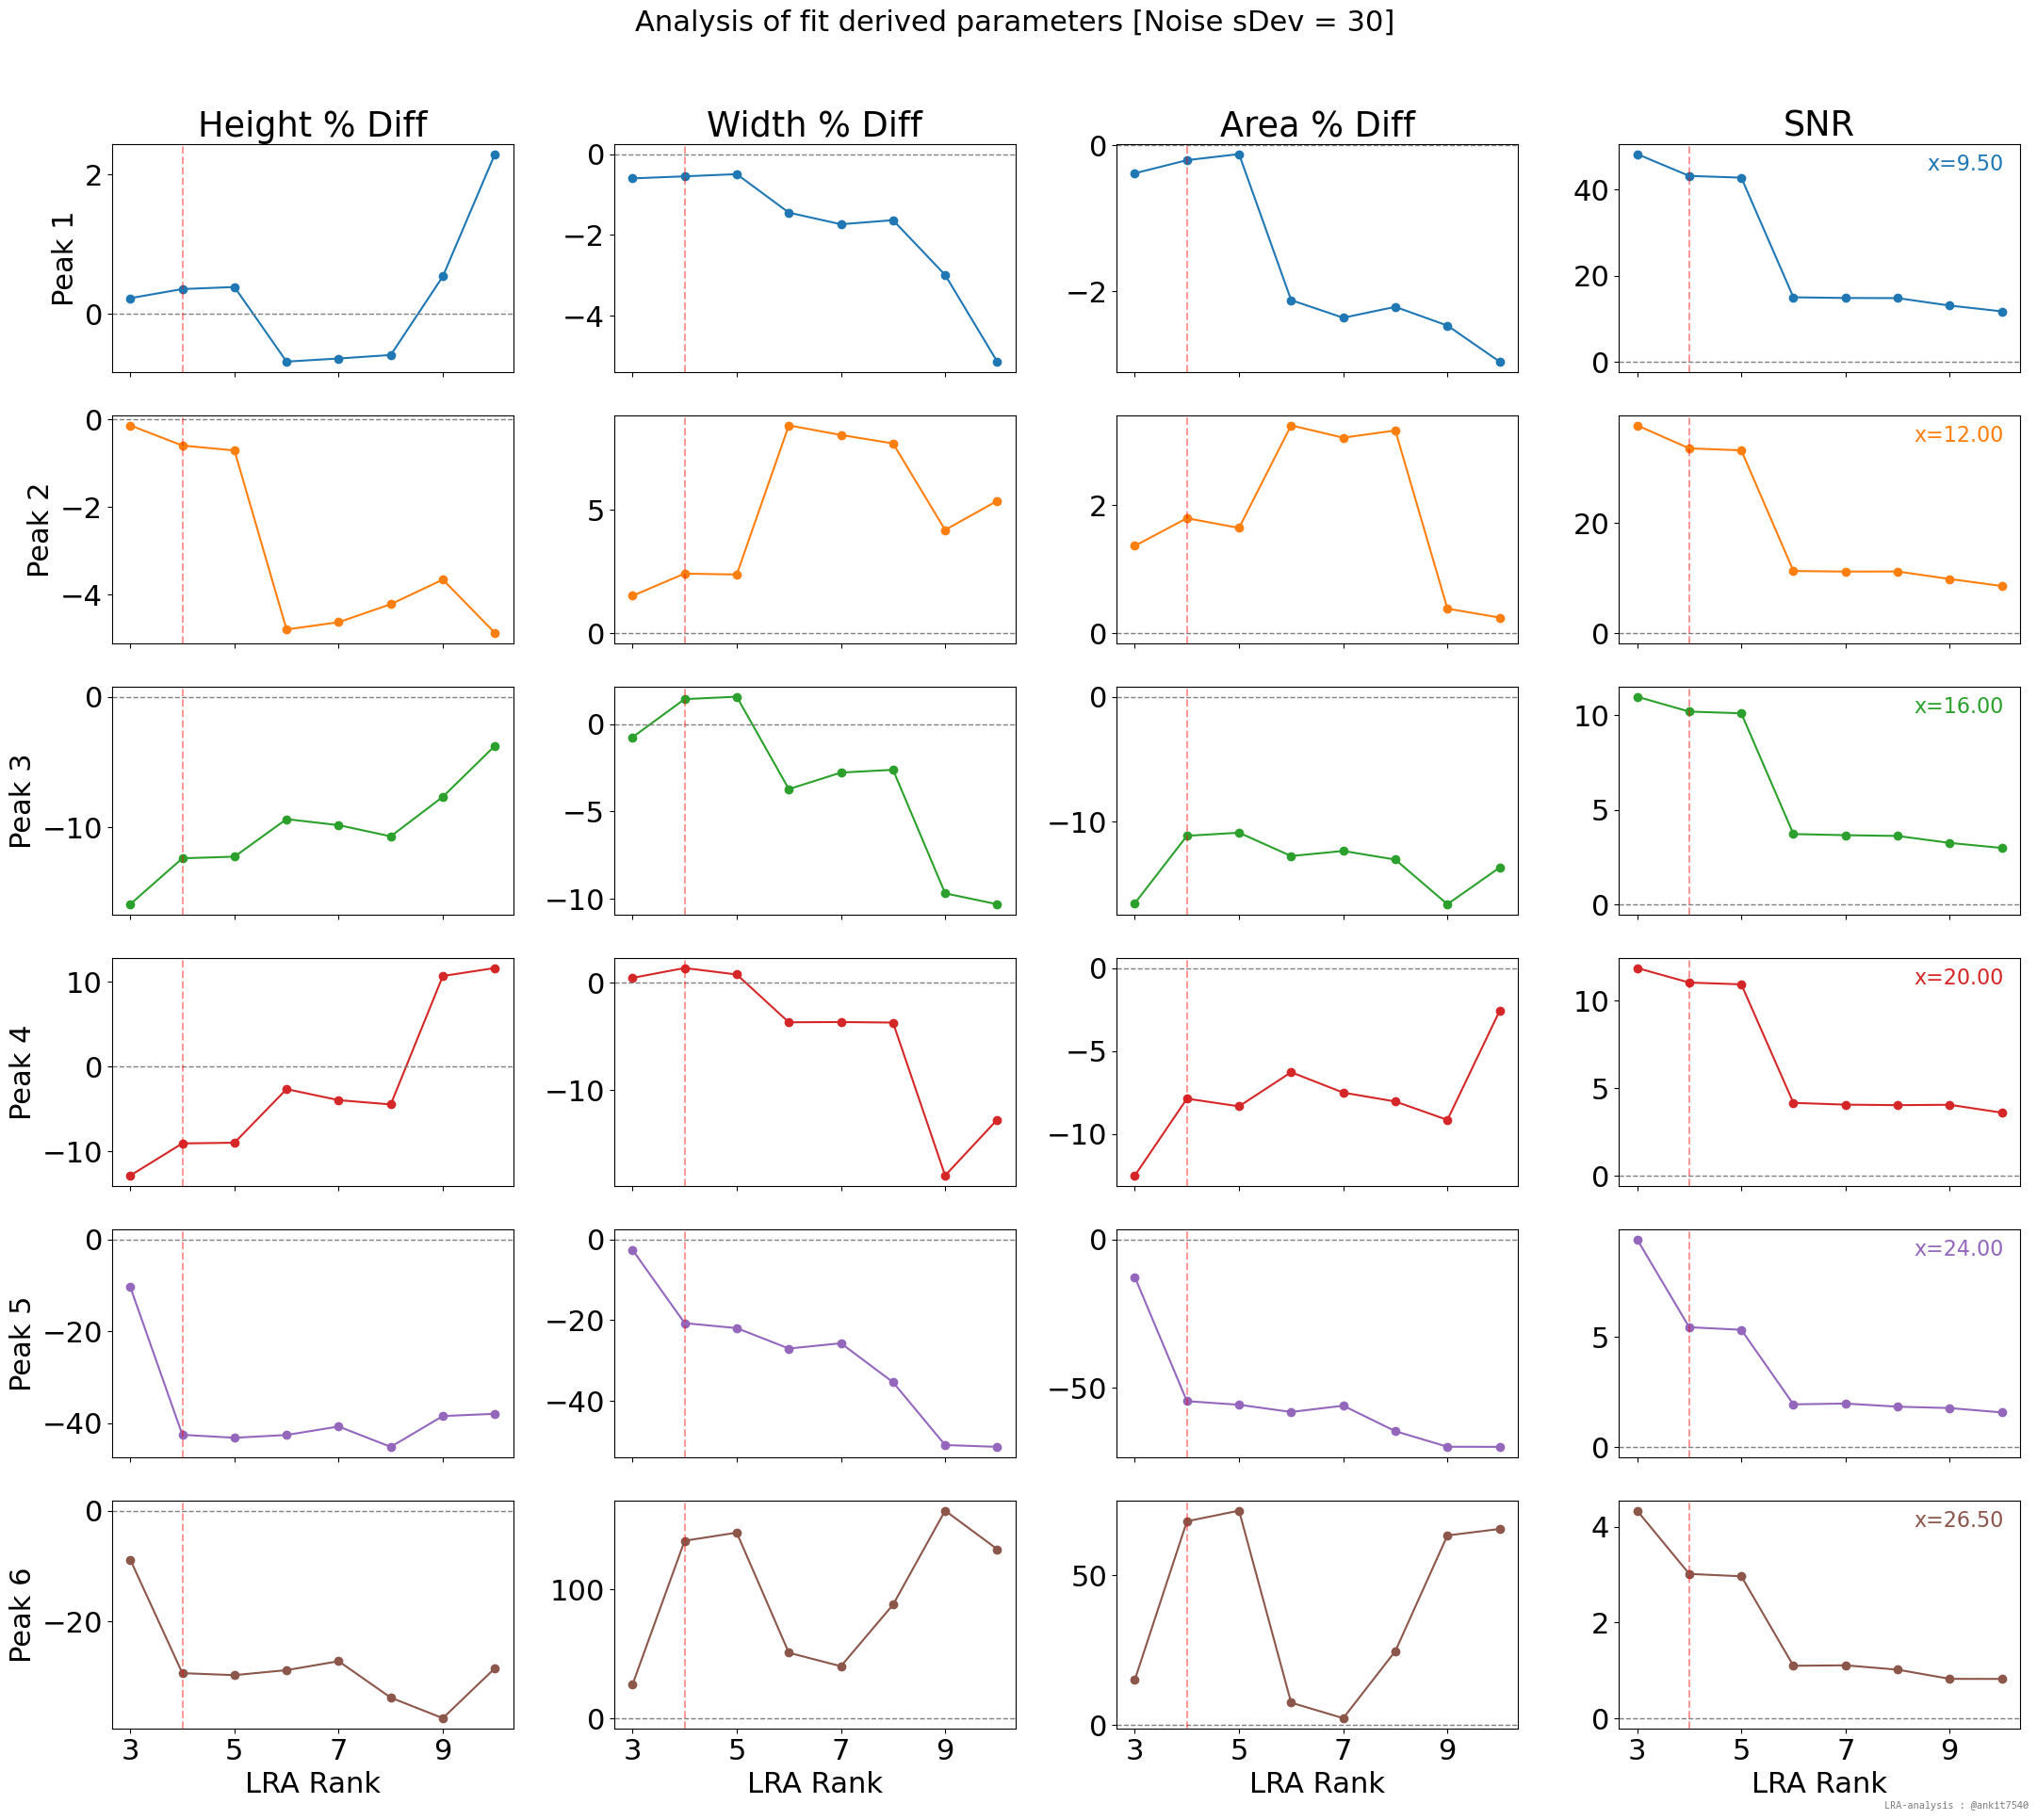

In [10]:
import matplotlib.pyplot as plt

# Determine number of peaks
n_peaks = len(true_params)
labels = [str(i + 1) for i in range(n_peaks)]
titles = ["Height % Diff", "Width % Diff",   "Area % Diff", "SNR"]
err_titles = ["Height % Fit Error", "Position % Fit Error", "Width % Fit Error"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]

odd_ranks = [r for r in ranks if r % 2 == 1]

# === Plot 1: % Difference and SNR ===
fig1, axes1 = plt.subplots(n_peaks, 4, figsize=(22, 3.2 * n_peaks), sharex=True)
fig1.suptitle(f"Analysis of fit derived parameters [Noise sDev = {Noise_sDev}]", fontsize=22, y=1.006)

for i in range(n_peaks):
    axes1[i, 0].plot(ranks, results[i]["height"], marker='o', color=colors[i])
    axes1[i, 1].plot(ranks, results[i]["width"], marker='o', color=colors[i])
    axes1[i, 2].plot(ranks, results[i]["area"], marker='o', color=colors[i])
    axes1[i, 3].plot(ranks, results[i]["snr"], marker='o', color=colors[i])
    
    axes1[i, 3].text(
        0.96, 0.96, f"x={true_params[i]['x0']:.2f}",
        transform=axes1[i, 3].transAxes,
        ha='right', va='top',
        fontsize=16, color=colors[i],
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.78)
    )

    for j in range(4):  # horizontal line only for diff plots
        axes1[i, j].axhline(0, color='grey', ls='--', lw=1)
    
    for j in range(4):
        if i == 0:
            axes1[i, j].set_title(titles[j])
        if j == 0:
            axes1[i, j].set_ylabel(f"Peak {labels[i]}")

for ax in axes1[-1]:
    ax.set_xlabel("LRA Rank")
for ax_row in axes1:
    for ax in ax_row:
        ax.set_xticks(odd_ranks)

# Optional vertical line at cutoff
if 'cutoffV' in globals() and cutoffV > 2:
    for ax_row in axes1:
        for ax in ax_row:
            ax.axvline(cutoffV, color='red', linestyle='--', alpha=0.4)

plt.tight_layout()
# Attribution text (bottom right)
plt.figtext(
    0.989,         # x-coordinate in figure fraction
    0.01,         # y-coordinate in figure fraction
    "LRA-analysis : @ankit7540",  # Text content
    ha='right', 
    va='bottom',
    fontsize=8,
    color='gray',
    fontname='Consolas'  # Or try 'Arial Narrow'
)
plt.show()



